Нужно определить для каждой точки в исходном наборе данных к какому кластеру (классу) она относится. Моделью KNN будут являться метрики, алгоритмы, используемые в определении класса точек и присвоенные всем точкам их метки.

Задаем число кластеров. Возможно это можно сделать динамически, но для этого нужно придумать алгоритм, который будет делить данные на кластеры основываясь на каких-то общих закономерностях в данных, а не просто на основе расстояния.

Потом создаем центры кластеров, например, случайно. Можно задать центры кластеров по графику, на графике видно, в каких областях происходят скопления объектов, центрами кластеров будут центры этих областей.

Далее для каждой рассматриваемой точки нужно вычислить расстояние между рассматриваемой точкой данных и всеми центрами кластеров. Рассматриваем каждую точку в наборе данных, вычисляем расстояния до всех точек-центров кластеров, выбираем кластер, до которого наименьшее расстояние.

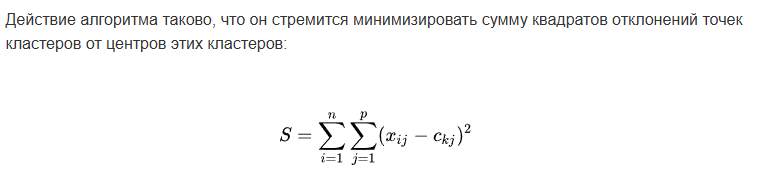

In [1]:
from IPython.display import Image
Image('square.png')

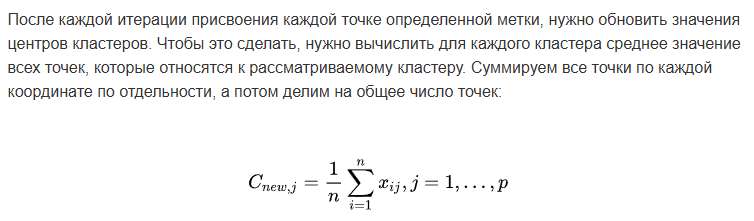

In [2]:
Image('new.png')

# Пошаговый алгоритм K-Means:
* Инициализация центроидов (случайно или через k-means++)
* E-шаг (assignment): присваиваем каждую точку ближайшему центру
* M-шаг (update): пересчитываем центры кластеров как среднее по точкам
* Повторяем, пока центры не перестанут изменяться (или max_iters)

## Ограничения:
Требуется заранее знать K

Не устойчив к выбросам

Плохо работает при наличии кластеров сложной формы (не шарообразные)



In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

In [7]:
class KMeans:
    def __init__(self, n_clusters=3, max_iter=100, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state


    def fit(self, X):
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape

        # Инициализация центров (K случайных точек)
        initial_idx = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.centroids = X[initial_idx] # Выбранные точки становятся начальными центрами

        for i in range(self.max_iter):
            # Присваиваем метки по ближайшему центру
            distances = self._compute_distance(X)
            self.labels_ = np.argmin(distances, axis=1) # Выбор ближайшего центра (по индексу)

            # Обновляем центры (Пересчитываем центры как среднее всех точек в каждом кластере)
            """
            X[self.labels_ == k] — это все точки, отнесённые к кластеру k.
            mean(axis=0) — вычисляет центр этих точек (новый центр кластера).
            Если кластер пустой, мы просто сохраняем старый центр (чтобы избежать ошибок).
            """
            new_centroids = np.array([X[self.labels_ == k].mean(axis=0) if len(X[self.labels_==k]) > 0 else self.centroids[k]
                                     for k in range(self.n_clusters)])

            # Проверка на сходимость (если центры почти не изменились, прекращаем)
            if np.linalg.norm(self.centroids - new_centroids) < self.tol:
                break

            self.centroids = new_centroids # Обновляем центры на текущей итерации


    def predict(self,X):
        distances = self._compute_distance(X)
        return np.argmin(distances, axis=1) # Метка ближайшего центра


    def _compute_distance(self, X):
        """
        X[:, np.newaxis] — добавляет новую ось → форма (n_samples, 1, n_features)
        self.centroids — форма (n_clusters, n_features)
        Вычитание (broadcasting) → матрица (n_samples, n_clusters, n_features)
        np.linalg.norm(..., axis=2) → вычисляем евклидово расстояние по каждому признаку        
        """
        return np.linalg.norm(X[:, np.newaxis]- self.centroids, axis=2)




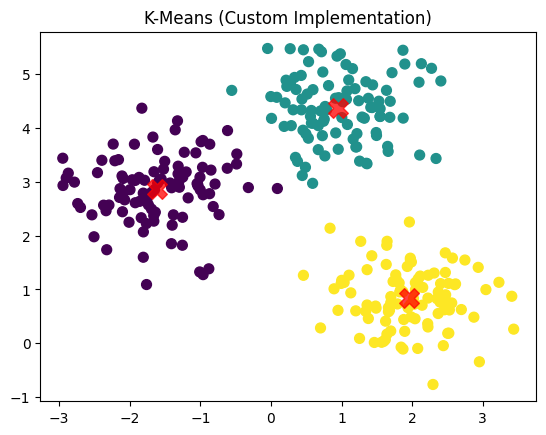

In [6]:
from sklearn.datasets import make_blobs

# Генерируем данные
X, y_true = make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=0)

# Обучим свою модель
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
y_pred = kmeans.labels_

# Визуализация
plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=50, cmap='viridis')
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title("K-Means (Custom Implementation)")
plt.show()


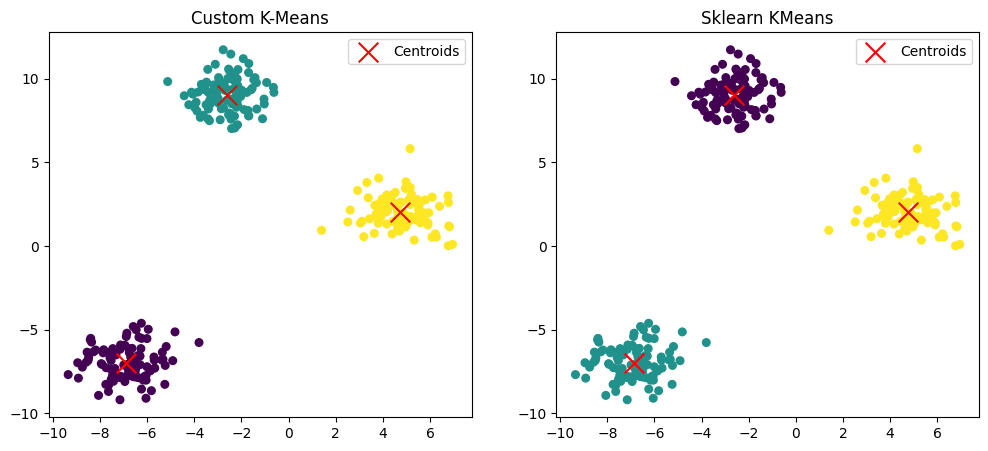

In [9]:
# 1. Данные
X, _ = make_blobs(n_samples=300, centers=3, random_state=42)

# 2. Склерн KMeans
kmeans_sklearn = KMeans(n_clusters=3, random_state=42, n_init='auto')
kmeans_sklearn.fit(X)
labels_sklearn = kmeans_sklearn.labels_
centroids_sklearn = kmeans_sklearn.cluster_centers_

# 3. Моя реализация (повторно)
from copy import deepcopy

def euclidean(a, b):
    return np.linalg.norm(a - b)

def kmeans_custom(X, k=3, max_iters=100):
    # Случайные начальные центры
    idx = np.random.choice(len(X), k, replace=False)
    centroids = X[idx]
    
    for _ in range(max_iters):
        # Назначение кластеров
        labels = np.array([np.argmin([euclidean(x, c) for c in centroids]) for x in X])
        
        # Обновление центроидов
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
        
        # Проверка сходимости
        if np.allclose(new_centroids, centroids):
            break
        centroids = new_centroids
        
    return labels, centroids

labels_custom, centroids_custom = kmeans_custom(X)

# 4. Визуализация
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Custom
axs[0].scatter(X[:, 0], X[:, 1], c=labels_custom, cmap='viridis', s=30)
axs[0].scatter(centroids_custom[:, 0], centroids_custom[:, 1], c='red', marker='x', s=200, label='Centroids')
axs[0].set_title('Custom K-Means')
axs[0].legend()

# Sklearn
axs[1].scatter(X[:, 0], X[:, 1], c=labels_sklearn, cmap='viridis', s=30)
axs[1].scatter(centroids_sklearn[:, 0], centroids_sklearn[:, 1], c='red', marker='x', s=200, label='Centroids')
axs[1].set_title('Sklearn KMeans')
axs[1].legend()

plt.show()


In [10]:
print("Custom Centroids:\n", centroids_custom)
print("Sklearn Centroids:\n", centroids_sklearn)


Custom Centroids:
 [[-6.88387179 -6.98398415]
 [-2.63323268  9.04356978]
 [ 4.74710337  2.01059427]]
Sklearn Centroids:
 [[-2.63323268  9.04356978]
 [-6.88387179 -6.98398415]
 [ 4.74710337  2.01059427]]


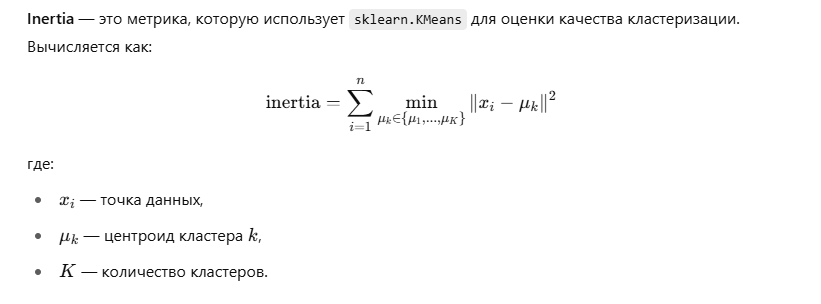

In [17]:
Image('../unsupervised/K-means/inertia.png')

In [20]:
class KMeansCustom:
    def __init__(self, n_clusters=3, max_iter=100, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.centroids = None
        self.labels_ = None
        self.inertia_ = None

    def fit(self, X):
        if self.random_state:
            np.random.seed(self.random_state)
        n_samples, _ = X.shape

        # Инициализация центроидов случайными точками из X
        random_idxs = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.centroids = X[random_idxs]

        for _ in range(self.max_iter):
            # Этап присваивания (assignment)
            distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
            labels = np.argmin(distances, axis=1)

            # Этап обновления центров
            new_centroids = np.array([
                X[labels == i].mean(axis=0) if len(X[labels == i]) > 0 else self.centroids[i]
                for i in range(self.n_clusters)
            ])

            # Проверка сходимости
            if np.allclose(self.centroids, new_centroids, atol=self.tol):
                break
            self.centroids = new_centroids

        self.labels_ = labels # Обновляем центры на текущей итерации

        # Вычисление inertia
        self.inertia_ = np.sum([
            np.sum((X[labels == i] - self.centroids[i]) ** 2)
            for i in range(self.n_clusters)
        ])
        return self 


    def predict(self,X):
        distances = self._compute_distance(X)
        return np.argmin(distances, axis=1) # Метка ближайшего центра


    def _compute_distance(self, X):
        """
        X[:, np.newaxis] — добавляет новую ось → форма (n_samples, 1, n_features)
        self.centroids — форма (n_clusters, n_features)
        Вычитание (broadcasting) → матрица (n_samples, n_clusters, n_features)
        np.linalg.norm(..., axis=2) → вычисляем евклидово расстояние по каждому признаку        
        """
        return np.linalg.norm(X[:, np.newaxis]- self.centroids, axis=2)

In [21]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans as SKKMeans

# Сгенерируем данные
X, _ = make_blobs(n_samples=300, centers=3, cluster_std=0.5, random_state=42)

# Наша реализация
kmeans_custom = KMeansCustom(n_clusters=3, random_state=42)
kmeans_custom.fit(X)

print("Custom inertia:", kmeans_custom.inertia_)

# sklearn
sk_kmeans = SKKMeans(n_clusters=3, random_state=42, n_init='auto')
sk_kmeans.fit(X)

print("Sklearn inertia:", sk_kmeans.inertia_)


Custom inertia: 141.7148877811033
Sklearn inertia: 141.7148877811033


## Свойства:

* Алгоритм локально оптимален, зависит от начальных центров

* Работает быстро: 𝑂(𝑛⋅𝑘⋅𝑑⋅𝑡)

* Хорош для сферических кластеров одинакового размера

* Плохо справляется с:

    * вытянутыми или перекрывающимися кластерами
    
    * чувствителен к выбросам и инициализации